In [1]:
!python3 -m spacy download en_core_web_lg

2023-05-30 01:53:43.644822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 01:53:44.789892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
import spacy
from spacy import displacy

# Load the SpaCy model
nlp = spacy.load('en_core_web_lg')

# Sample sentence in the IT domain
sentence = " The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises. This router is an excellent choice for those who demand high-performance, reliable, and secure Wi-Fi connectivity for their business or personal use. One of the most notable features of the Ruckus R550 is its support for the latest Wi-Fi 6 (802.11ax) standard. This new standard offers improved speeds, better range, and increased capacity compared to previous Wi-Fi standards. With Wi-Fi 6, you can experience faster downloads, smoother streaming, and better overall performance, especially in environments with many connected devices. The R550 offers dual-band connectivity, with support for both the 2.4 GHz and 5 GHz bands. This allows you to take advantage of the full capabilities of Wi-Fi 6, as well as support legacy devices that only support older Wi-Fi standards. The router also features advanced adaptive antenna technology, which enables it to automatically adjust its antennas to optimize signal strength and quality. Another important feature of the R550 is its support for MU-MIMO (Multi-User Multiple Input Multiple Output) technology. This allows the router to communicate with multiple devices simultaneously, which can improve overall network performance and reduce latency. MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently. The R550 also supports SmartMesh wireless mesh networking technology, which allows you to extend your Wi-Fi coverage by creating a mesh network with multiple access points. This is ideal for larger homes or offices where a single router may not provide adequate coverage. In terms of security, the R550 supports a range of advanced features to help protect your network from unauthorized access and attacks. These include WPA2-PSK, WPA2-Enterprise, MAC address filtering, VLAN support, and HTTPS login. The router also supports cloud management through Ruckus Cloud or on-premises management with ZoneDirector or SmartZone controllers, giving you complete control over your network and its security. Overall, the Ruckus R550 is an excellent choice for anyone looking for a high-performance Wi-Fi 6 router. Its advanced features, including MU-MIMO, adaptive antenna technology, and SmartMesh support, make it ideal for homes and businesses with many connected devices. And with its robust security features and cloud management capabilities, you can be sure that your network is safe and secure."

# Perform NER
doc = nlp(sentence)

# Visualize the named entities in the sentence
displacy.render(doc, style="ent", jupyter=True)


In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')

doc = nlp("IP address of the router is 192.0.2.1 ")

for tok in doc:
  print(tok.text, "...", tok.dep_)

IP ... compound
address ... nsubj
of ... prep
the ... det
router ... pobj
is ... ROOT
192.0.2.1 ... attr


In [4]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [5]:

import pandas as pd
import nltk
nltk.download('punkt')

#text = "The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises. This router is an excellent choice for those who demand high-performance, reliable, and secure Wi-Fi connectivity for their business or personal use. One of the most notable features of the Ruckus R550 is its support for the latest Wi-Fi 6 (802.11ax) standard. This new standard offers improved speeds, better range, and increased capacity compared to previous Wi-Fi standards. With Wi-Fi 6, you can experience faster downloads, smoother streaming, and better overall performance, especially in environments with many connected devices. The R550 offers dual-band connectivity, with support for both the 2.4 GHz and 5 GHz bands. This allows you to take advantage of the full capabilities of Wi-Fi 6, as well as support legacy devices that only support older Wi-Fi standards. The router also features advanced adaptive antenna technology, which enables it to automatically adjust its antennas to optimize signal strength and quality. Another important feature of the R550 is its support for MU-MIMO (Multi-User Multiple Input Multiple Output) technology. This allows the router to communicate with multiple devices simultaneously, which can improve overall network performance and reduce latency. MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently. The R550 also supports SmartMesh wireless mesh networking technology, which allows you to extend your Wi-Fi coverage by creating a mesh network with multiple access points. This is ideal for larger homes or offices where a single router may not provide adequate coverage. In terms of security, the R550 supports a range of advanced features to help protect your network from unauthorized access and attacks. These include WPA2-PSK, WPA2-Enterprise, MAC address filtering, VLAN support, and HTTPS login. The router also supports cloud management through Ruckus Cloud or on-premises management with ZoneDirector or SmartZone controllers, giving you complete control over your network and its security. Overall, the Ruckus R550 is an excellent choice for anyone looking for a high-performance Wi-Fi 6 router. Its advanced features, including MU-MIMO, adaptive antenna technology, and SmartMesh support, make it ideal for homes and businesses with many connected devices. And with its robust security features and cloud management capabilities, you can be sure that your network is safe and secure."
text = "The Ruckus R550 is a cutting-edge Wi-Fi router that offers high-performance wireless connectivity for demanding environments. With its advanced features and robust design, it delivers reliable and fast wireless connectivity to support a large number of devices. Let's delve into the device specifications of the Ruckus R550.The R550 supports the latest Wi-Fi 6 (802.11ax) standard, providing faster speeds and improved efficiency. It is also backward compatible with older Wi-Fi standards, including 802.11ac Wave 2, 802.11n, 802.11a, 802.11g, and 802.11b. The router can deliver a total throughput of up to 1.8 Gbps, ensuring high-speed connections for multiple devices simultaneously. The R550 operates on both the 2.4GHz and 5GHz frequency bands, allowing for greater flexibility and less interference. The 2.4GHz band provides better coverage over longer distances, while the 5GHz band offers faster speeds for devices in close proximity to the router. The R550 is equipped with two Gigabit Ethernet ports. One port is used for connecting to the internet or WAN (Wide Area Network), while the other port can be used to connect to a switch or other wired network devices. These Ethernet ports allow for seamless integration into existing networks and provide wired connectivity options when needed. The R550 supports Power over Ethernet (PoE), which simplifies installation and eliminates the need for a separate power supply. With PoE, the router can be powered through the Ethernet cable, making it easier to deploy in locations where power outlets may be limited. The R550 can be managed and monitored through various methods. It is compatible with the Ruckus Cloud management platform, which provides a centralized interface for managing multiple access points and configuring network settings. Additionally, the router supports SNMP (Simple Network Management Protocol) for integration with network management systems, allowing for seamless integration into existing network infrastructure. The R550 incorporates robust security features to protect against unauthorized access and threats. It supports the WPA3 security standard, which provides enhanced encryption and authentication protocols for secure wireless connections. The router also features a built-in firewall and intrusion detection/prevention capabilities, ensuring network security and safeguarding against potential attacks. The Ruckus R550 has a compact and sleek design, making it easy to integrate into various environments. It is designed to be mounted on a wall or ceiling using the included mounting brackets, providing flexibility in deployment options. The router's physical dimensions are approximately [insert dimensions] and it weighs around [insert weight]. In conclusion, the Ruckus R550 is an advanced Wi-Fi router that offers high-performance wireless connectivity. With its support for Wi-Fi 6, dual-band operation, multiple Ethernet ports, and robust security features, the R550 is an excellent choice for organizations looking to provide reliable and fast wireless connectivity in demanding environments."
sentences = nltk.sent_tokenize(text)
df = pd.DataFrame(columns=['Sentences'])
rows_list = []

for sentence in sentences:
    rows_list.append({'Sentences': sentence})
df = pd.DataFrame(rows_list)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [7]:

# import wikipedia sentences
candidate_sentences = df
candidate_sentences.shape

(23, 1)

In [8]:
candidate_sentences.head()

,Sentences
0,The Ruckus R550 is a cutting-edge Wi-Fi router that offers high-performance wireless connectivity for demanding environments.
1,"With its advanced features and robust design, it delivers reliable and fast wireless connectivity to support a large number of devices."
2,"Let's delve into the device specifications of the Ruckus R550.The R550 supports the latest Wi-Fi 6 (802.11ax) standard, providing faster speeds and improved efficiency."
3,"It is also backward compatible with older Wi-Fi standards, including 802.11ac Wave 2, 802.11n, 802.11a, 802.11g, and 802.11b."
4,"The router can deliver a total throughput of up to 1.8 Gbps, ensuring high-speed connections for multiple devices simultaneously."


In [9]:
candidate_sentences['Sentences']

0                                                                               The Ruckus R550 is a cutting-edge Wi-Fi router that offers high-performance wireless connectivity for demanding environments.
1                                                                     With its advanced features and robust design, it delivers reliable and fast wireless connectivity to support a large number of devices.
2                                    Let's delve into the device specifications of the Ruckus R550.The R550 supports the latest Wi-Fi 6 (802.11ax) standard, providing faster speeds and improved efficiency.
3                                                                               It is also backward compatible with older Wi-Fi standards, including 802.11ac Wave 2, 802.11n, 802.11a, 802.11g, and 802.11b.
4                                                                           The router can deliver a total throughput of up to 1.8 Gbps, ensuring high-speed connections for mul

In [10]:
#check the subject and object of one of these sentences. 
#Ideally, there should be one subject and one object in the sentence:
doc = nlp("The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises.R550 is is the ON state. R550 has port 1 empty.")
for tok in doc:
  print(tok.text, "...", tok.dep_)
#There is only one subject (‘process’) and only one object (‘standard’)

The ... det
Ruckus ... compound
R550 ... nsubj
is ... ROOT
a ... det
powerful ... amod
and ... cc
feature ... npadvmod
- ... punct
packed ... conj
Wi ... compound
- ... punct
Fi ... nmod
6 ... nummod
router ... attr
that ... nsubjpass
is ... auxpass
designed ... relcl
for ... prep
indoor ... amod
use ... pobj
in ... prep
homes ... pobj
, ... punct
small ... amod
offices ... conj
, ... punct
and ... cc
medium ... amod
- ... punct
sized ... amod
enterprises ... conj
. ... punct
R550 ... nsubj
is ... ROOT
is ... ccomp
the ... det
ON ... compound
state ... nsubj
. ... punct
R550 ... nsubj
has ... aux
port ... ROOT
1 ... dobj
empty ... advmod
. ... punct


In [11]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [12]:
get_entities("MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently.")


['connected  it', 'multiple  connections']

In [13]:

entity_pairs = []

for i in tqdm(candidate_sentences["Sentences"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 23/23 [00:00<00:00, 81.28it/s]


In [14]:
entity_pairs[0:20]

[['cutting Wi Fi that', 'performance wireless performance environments'],
 ['robust  it', 'large  devices'],
 ["'s", 'faster Wi speeds'],
 ['It', '802.11ac Wi Fi Wave'],
 ['router', 'multiple speed devices'],
 ['R550', 'greater frequency flexibility'],
 ['5GHz  band', 'close  router'],
 ['R550', 'two Gigabit Ethernet ports'],
 ['other Wide Area port', 'switch'],
 ['Ethernet ports', 'wired connectivity options'],
 ['which', 'separate power supply'],
 ['where power outlets', 'locations'],
 ['R550', 'various  methods'],
 ['Cloud management which', 'multiple network settings'],
 ['Additionally  router', 'existing network infrastructure'],
 ['R550', 'unauthorized security access'],
 ['WPA3 security which', 'wireless  connections'],
 ['router', 'potential network attacks'],
 ['compact  it', 'various  environments'],
 ['It', 'mounting deployment options']]

In [15]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]] 
  
  matcher.add("matching_1",pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [16]:
get_relation("MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently.")

'is'

In [17]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Sentences'])]


100%|██████████| 23/23 [00:00<00:00, 92.62it/s]


In [18]:
for i in range(0,len(relations)):
  print(entity_pairs[i][0] + "------" + relations[i] + "------ " + entity_pairs[i][1])

cutting Wi Fi that------is------ performance wireless performance environments
robust  it------delivers reliable------ large  devices
's------supports------ faster Wi speeds
It------is------ 802.11ac Wi Fi Wave
router------deliver------ multiple speed devices
R550------operates on------ greater frequency flexibility
5GHz  band------provides better------ close  router
R550------equipped with------ two Gigabit Ethernet ports
other Wide Area port------used for------ switch
Ethernet ports------allow for seamless------ wired connectivity options
which------supports------ separate power supply
where power outlets------powered through------ locations
R550------managed------ various  methods
Cloud management which------is compatible------ multiple network settings
Additionally  router------supports------ existing network infrastructure
R550------incorporates robust------ unauthorized security access
WPA3 security which------supports------ wireless  connections
router------features------ potent

In [19]:
pd.Series(relations).value_counts()[:50]

is                     4
supports               4
powered through        1
designed               1
has                    1
features               1
incorporates robust    1
is compatible          1
managed                1
allow for seamless     1
delivers reliable      1
used for               1
equipped with          1
provides better        1
operates on            1
deliver                1
are                    1
dtype: int64

In [20]:

# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [21]:
# create a directed-graph from a dataframe

G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

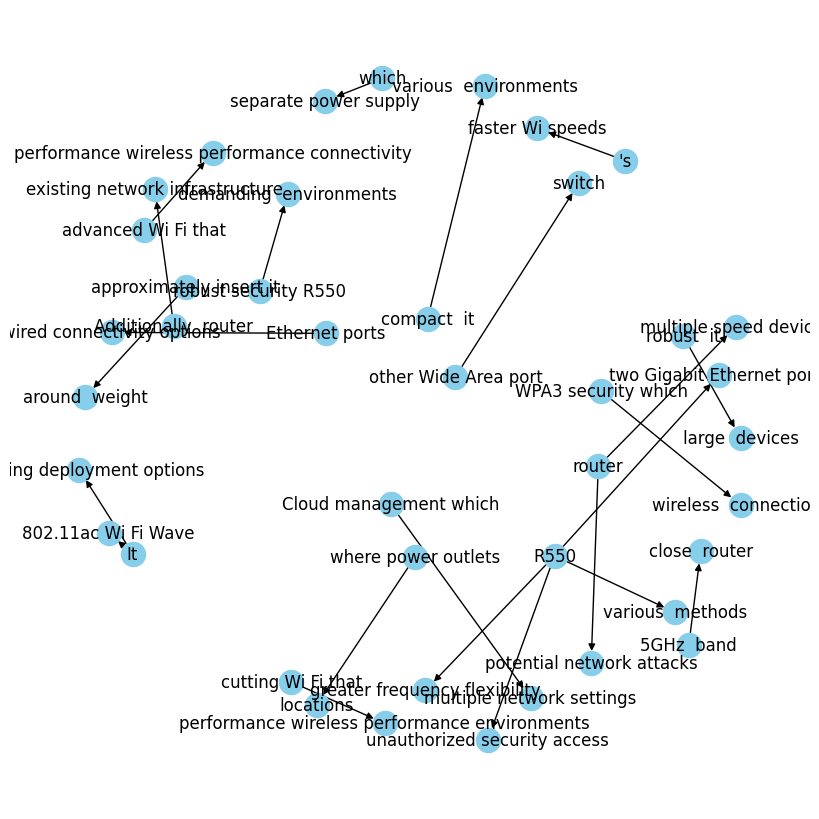

In [22]:
plt.figure(figsize=(8,8))

pos = nx.spring_layout(G,k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

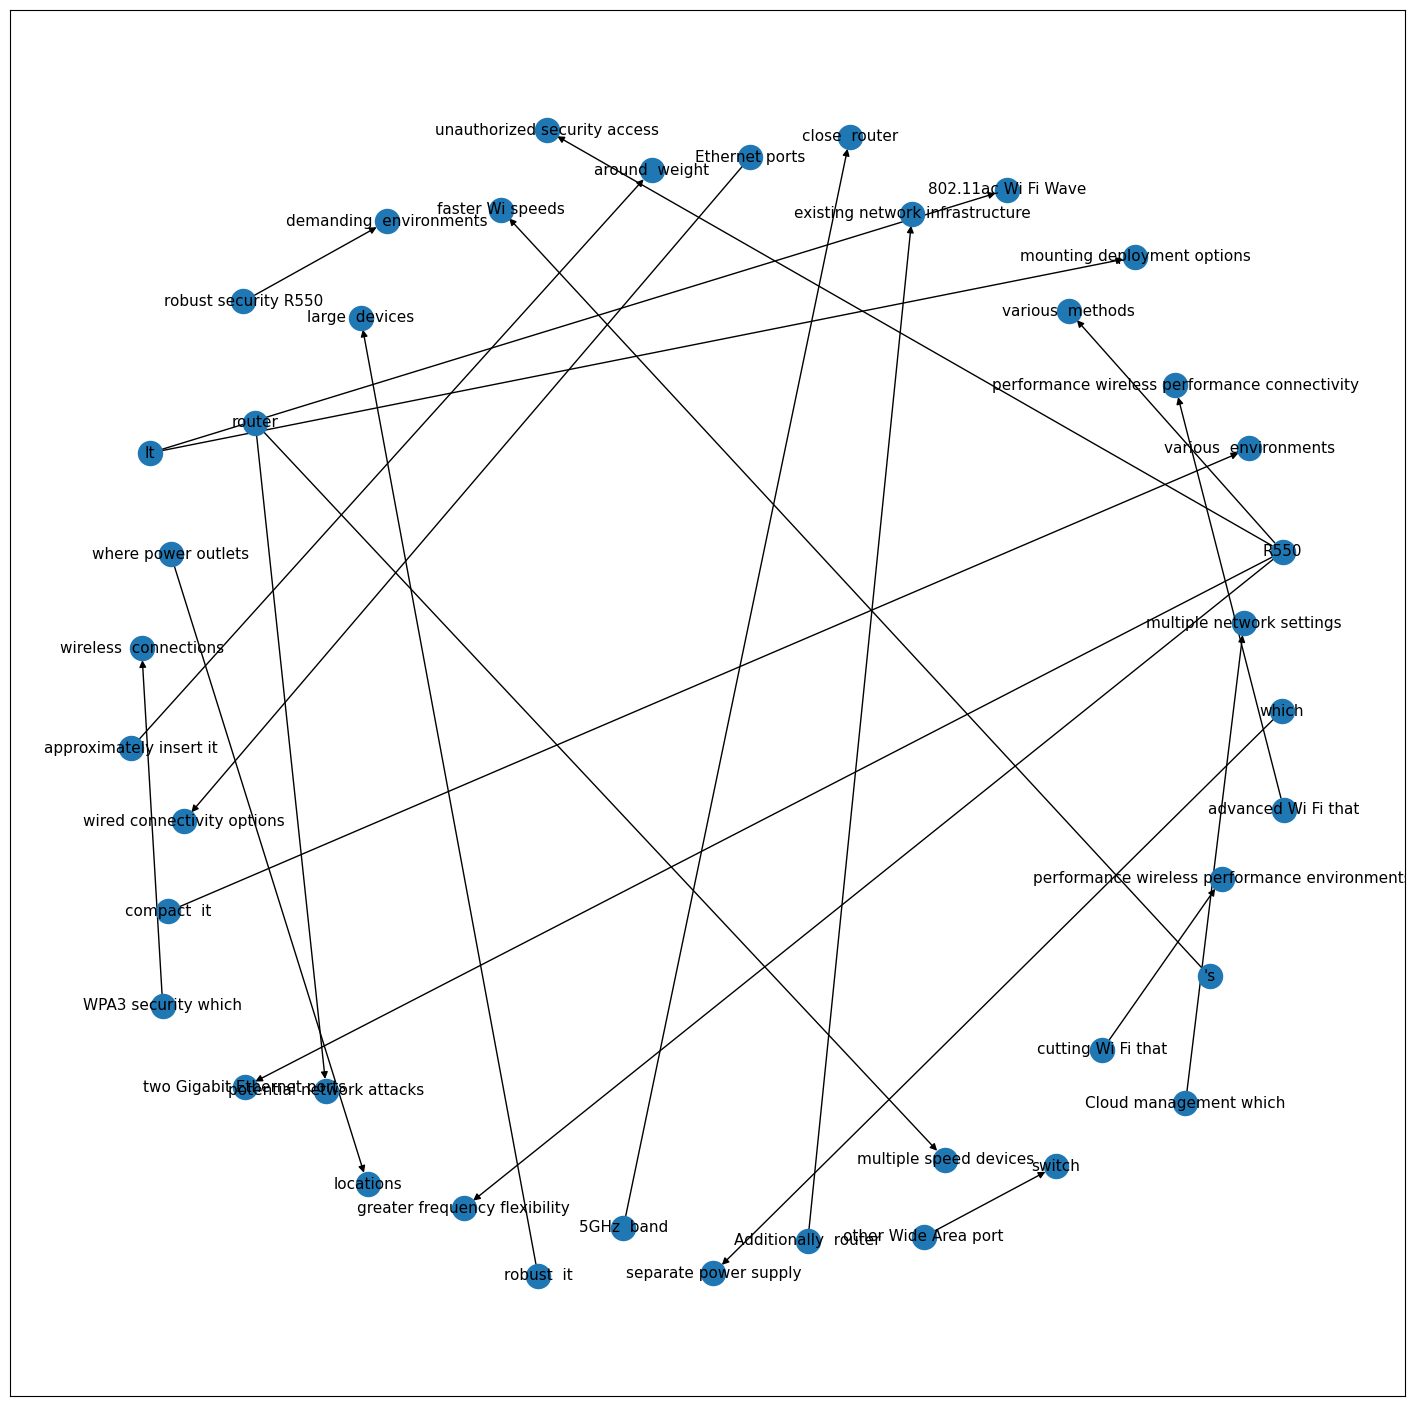

In [54]:


plt.figure(figsize=(18,18))
pos = nx.spring_layout(G, k = 15) # k regulates the distance between nodes
#nx.draw(G, with_labels=True, node_color='skyblue', node_size=150, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx(G,font_size = 11,pos=pos)
plt.show()

In [24]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy.language import Language

nlp = spacy.load("en_core_web_lg")

ruler = nlp.add_pipe("entity_ruler")
patterns = [{"label":"middleboxes","pattern":"firewall"},{"label":"middleboxes","pattern":"router"}\
            ,{"label":"action","pattern":"add"},{"label":"action","pattern":"block"},{"label":"action","pattern":"create"},{"label":"action","pattern":"disable"} \
            ,{"label":"action","pattern":"enable"},{"label":"action","pattern":"Inspect"} \
            ,{"label":"target","pattern":"backend"},{"label":"target","pattern":"laptop"},{"label":"target","pattern":"system"}]

ruler.add_patterns(patterns)



In [25]:
patterns = [{"label":"middleboxes","pattern":"firewall"},{"label":"middleboxes","pattern":"router"}]\
            +[{"label":"action","pattern":"add"},{"label":"action","pattern":"block"},{"label":"action","pattern":"create"},{"label":"action","pattern":"disable"}]\
            +[{"label":"action","pattern":"enable"},{"label":"action","pattern":"Inspect"}]\
            +[{"label":"target","pattern":"backend"},{"label":"target","pattern":"laptop"},{"label":"target","pattern":"system"}]


In [26]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler']


In [27]:
task = "please add router R550 to backend"

doc = nlp(task)

for ent in doc.ents:
  print(ent.text,"----",ent.label_)

add ---- action
router ---- middleboxes
R550 ---- PRODUCT
backend ---- target


In [28]:
nodes = {}

for ent in doc.ents:
  for device in ent.text:
    if ent.label_ == "middleboxes" or ent.label_ == "PRODUCT":
      nodes[ent.text]=nx.shortest_path(G,ent.text).keys()

In [56]:
for node in nodes:
  print(node,":")
  for comp in nodes[node]:
    print("         ",comp)

router :
          router
          multiple speed devices
          potential network attacks
R550 :
          R550
          greater frequency flexibility
          two Gigabit Ethernet ports
          various  methods
          unauthorized security access
